In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

directory = os.path.dirname(os.path.abspath(os.getcwd()))
data_path = os.path.join(directory, "data")
file_path = os.path.join(data_path, "cr2_prAmon_2018_ghcn/cr2_prAmon_2018_ghcn.txt")

raw = pd.read_table(file_path, sep=",", index_col=0, na_values=[-9999, "-"],
                    low_memory=False)
table = raw.transpose()
groups = table.columns.to_series().groupby(table.dtypes).groups

table[table.columns.values[14:]] = table[table.columns.values[14:]].apply(pd.to_numeric)
table[['altura', 'latitud', 'longitud', 'codigo_cuenca', 'codigo_sub_cuenca', 'cantidad_observaciones']] = table[
    ['altura', 'latitud', 'longitud', 'codigo_cuenca', 'codigo_sub_cuenca', 'cantidad_observaciones']].apply(
    pd.to_numeric)
table[['inicio_observaciones', 'fin_observaciones', 'inicio_automatica']] = \
    table[['inicio_observaciones', 'fin_observaciones', 'inicio_automatica']].apply(pd.to_datetime)


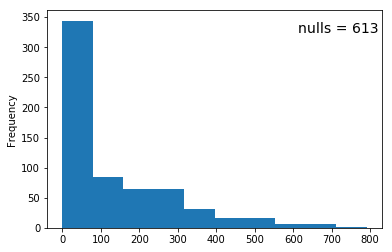

In [2]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

c = table['1995-07']
ax = c.plot.hist(use_index=True)
plt.text(0.75, 0.95, f"nulls = {c.isnull().sum()}", transform=ax.transAxes, fontsize=14,
         verticalalignment='top')
plt.show()


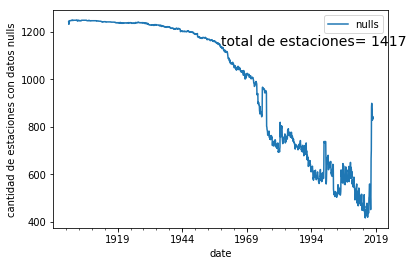

In [3]:

k = table[table.columns.values[14:]].isnull().sum()
k.index.name = 'meses'
k.index = k.index.map(lambda x: pd.Period(x))

dates = k.index.values
ts = pd.DataFrame({'date': dates,
                   'nulls': k.values}).set_index('date')
ax1 = ts.plot()
plt.text(0.5, 0.9, f"total de estaciones= {k.size}", transform=ax.transAxes, fontsize=14,
         verticalalignment='top')
ax1.set_ylabel("cantidad de estaciones con datos nulls")

plt.show()


In [4]:
def region(lat, lng):
    if lat > -27.6307621:
        return 0  # "Norte Grande"
    if lat > -32.759362:
        return 1  # "Norte Chico"
    if lat > -38.0613847:
        return 2  # "Central"
    if lat > -43.7890687:
        return 3  # "Sur"
    if lat > -56:
        return 4  # "Austral"
    else:
        return 5  # "Antartica"


def str_region(n):
    if n == 0:
        return "Norte Grande"
    if n == 1:
        return "Norte Chico"
    if n == 2:
        return "Central"
    if n == 3:
        return "Sur"
    if n == 4:
        return "Austral"
    else:
        return "Antartica"


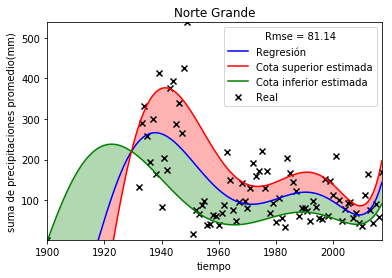

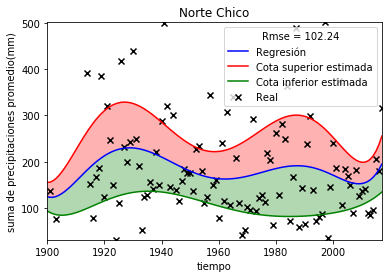

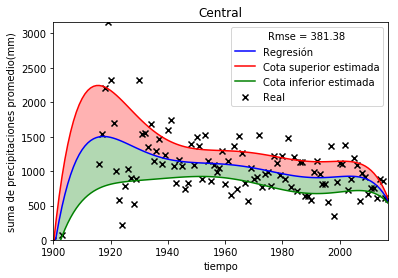

/home/dagum95/dev/lib/python3.6/site-packages/ipykernel_launcher.py:43: RankWarning: Polyfit may be poorly conditioned
/home/dagum95/dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/dagum95/dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RankWarning: Polyfit may be poorly conditioned


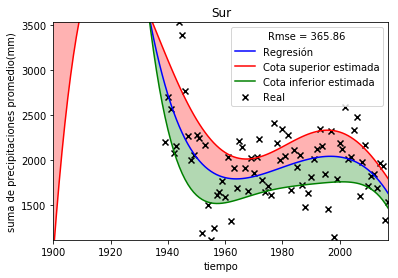

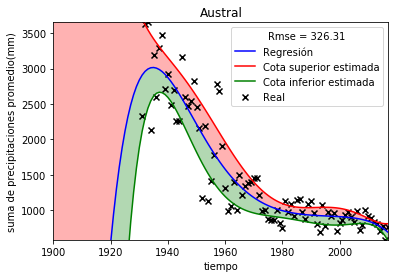

/home/dagum95/dev/lib/python3.6/site-packages/ipykernel_launcher.py:43: RankWarning: Polyfit may be poorly conditioned
/home/dagum95/dev/lib/python3.6/site-packages/ipykernel_launcher.py:54: RankWarning: Polyfit may be poorly conditioned
/home/dagum95/dev/lib/python3.6/site-packages/ipykernel_launcher.py:57: RankWarning: Polyfit may be poorly conditioned


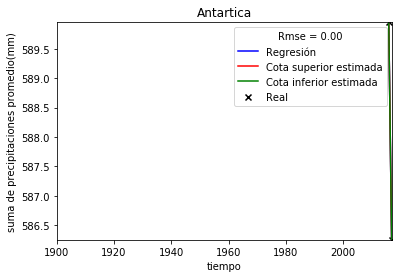

In [5]:
table = table[table.index.map(lambda x: x.isdigit())]
zona = table[['latitud', 'longitud']].apply(lambda x: region(x['latitud'], x['longitud']), axis=1)
table['zona'] = zona
import sys

def groupByYear(row):
    # print(row)
    gby = row.groupby(row.index.year,axis=0).sum()
    #print(gby)
    return gby #sys.exit(0)
    


#table = table.reset_index()
#print(table.index.values)




gb = table[table.columns.values[14:]].groupby(['zona'], axis=0)
final = gb.apply(lambda x: x[:-1].mean())
final.index = final['zona']
final = final.drop(['zona'], axis=1)
final.columns = final.columns.map(lambda x: pd.Period(x))
bby = final.apply(lambda x: groupByYear(x), axis = 1)

from scipy import interpolate

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())



    
for i, row in bby.iterrows():
    # axn = row[:-1].plot()
    deg = 6
    row = row[:-1]
    
    full = row.copy().index
    row = row[row > 0]
    
    z = np.polyfit(row.index, row.values,deg)
    f = np.poly1d(z)
    c1 = f(row.index)
    
    xt = row.index
    ecm = rmse(c1,row.values)
    error = np.abs(c1 - row.values)
    
    c2 = c1 + error
    c3 = c1-error
    
    z1 = np.polyfit(xt, c2,deg)
    f1 = np.poly1d(z1)
    
    z2 = np.polyfit(xt,c3,deg)
    f2 = np.poly1d(z2)
    
    c4 = f1(full)
    c5 = f2(full)
    
    plt.plot(full,f(full),color = "b", label = "Regresión")
    plt.plot(full,c4,color = "red" , label = "Cota superior estimada")
    plt.plot(full,c5,color = "green", label = "Cota inferior estimada")
    
    plt.fill_between(full, f(full), c4, facecolor='red', interpolate=True,alpha = 0.3)
    plt.fill_between(full, f(full), c5, facecolor='green', interpolate=True, alpha = 0.3)
    
    plt.scatter(xt,row.values, marker = 'x', color="black", label = "Real")
    
    plt.title(str_region(i))
    plt.axis((full.min(), full.max(), row.values.min(),row.values.max()))
    #plt.axis((full.min(), full.max(), 0,2500))
    plt.legend(title = f"Rmse = {ecm:.2f}")
    plt.xlabel("tiempo")
    plt.ylabel("suma de precipitaciones promedio(mm)")
    plt.show()

In [6]:
import folium


years = [1950,1980,2000,2016]
maps = []

centers = {
    0.0 : [-23.286693,-68.8564846], 
    1.0 : [-29.7903304,-69.4052295 - 1],
    2.0 : [-33.9411375,-69.5328937 - 1],
    3.0 : [-39.6212413,-70.5302577 - 2],
    4.0 : [-48.244194,-70.58268 - 3],
    5.0 : [-66.0903647,-60.9262445 - 1]
}
bby = bby.reset_index()
for y in years:
    m = folium.Map(location=[-40,-70], tiles="Mapbox Bright", zoom_start=3.5)
    for i, row in bby.iterrows():
        folium.Circle(
          location=centers[row['zona']],
          #popup=row['codigo_estacion'],
          radius=row[y]*100,
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(m)
    maps += [m]
    


In [7]:
maps[0]

In [8]:
maps[-1]

/home/dagum95/dev/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


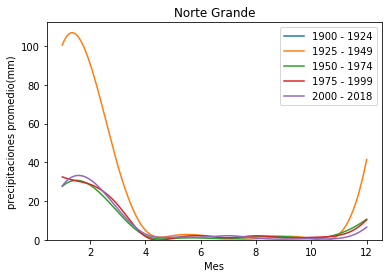

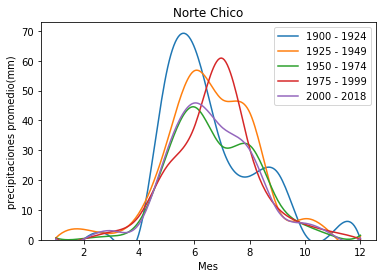

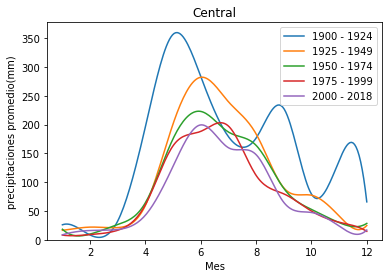

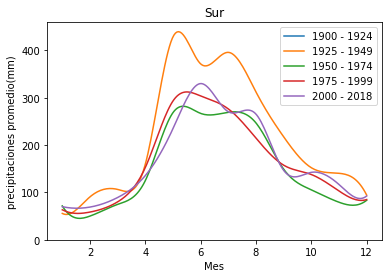

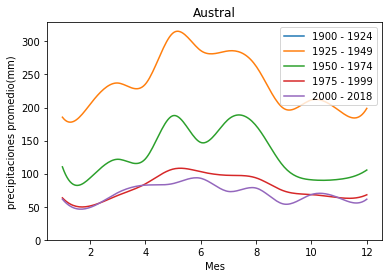

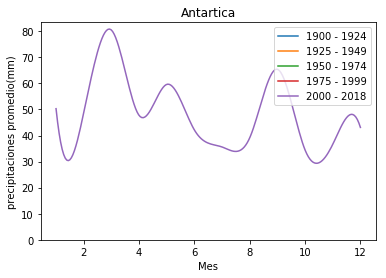

In [9]:
table_by = gb.apply(lambda x: x[:-1].mean())
table_by.index = table_by['zona']
table_by = table_by.drop(['zona'], axis=1)
table_by.columns = table_by.columns.map(lambda x: pd.Period(x))
months = np.array(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago",
                   "Sep","Oct","Nov","Dic"])


interval = 25

def interval_it(start,l):
    counter = start
    while 1:
        if counter + interval*12 <= l:
            yield (counter,counter + interval*12)
        else:
            yield (counter,l)
            break
        counter += interval*12
    
for i, row in table_by.iterrows():
    counter = 0
    it = interval_it(counter,len(table_by.columns))
    for (l,r) in it:
        prep = row[l:r]
        avg = []
        for k in range(1,13):
            month = prep[prep.index.map(lambda x: x.month == k)]
            avg += [month.mean()]
        
        #plt.plot(months,np.array(avg))
        x_smooth = np.linspace(1, 12, 200)
        y_smooth = interpolate.spline(np.array(range(1,13)), np.array(avg), x_smooth)
        plt.plot(x_smooth,y_smooth,label=f"{table_by.columns[l].year} - {table_by.columns[r-1].year}")
        # plt.plot(months,prep,label=f"{table_by.columns[l].year} - {table_by.columns[r-1].year}")
   
    plt.title(str_region(i))
    plt.ylim(ymin = 0)
    plt.xlabel("Mes")
    plt.ylabel("precipitaciones promedio(mm)")
    plt.legend(loc = "upper right")
    plt.show()
    
    
#table_by_year[table_by_year.columns[14:0]] = table_by

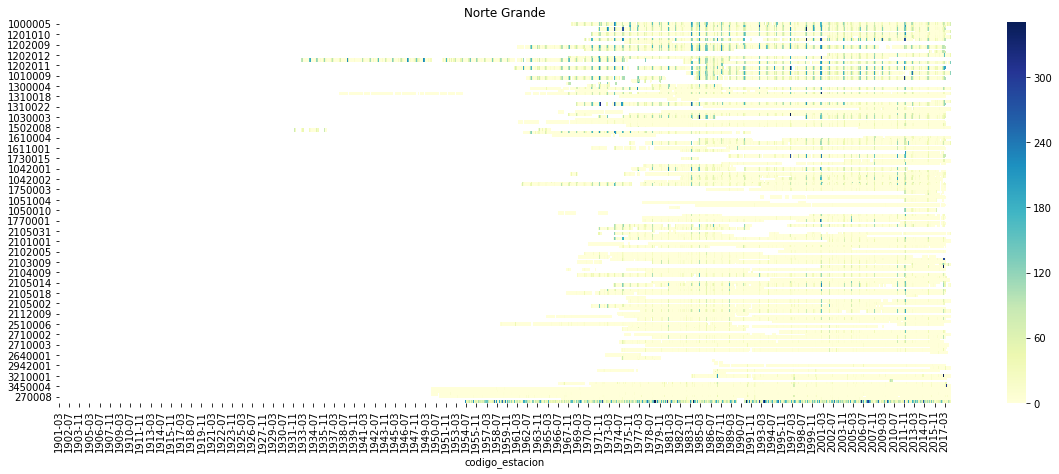

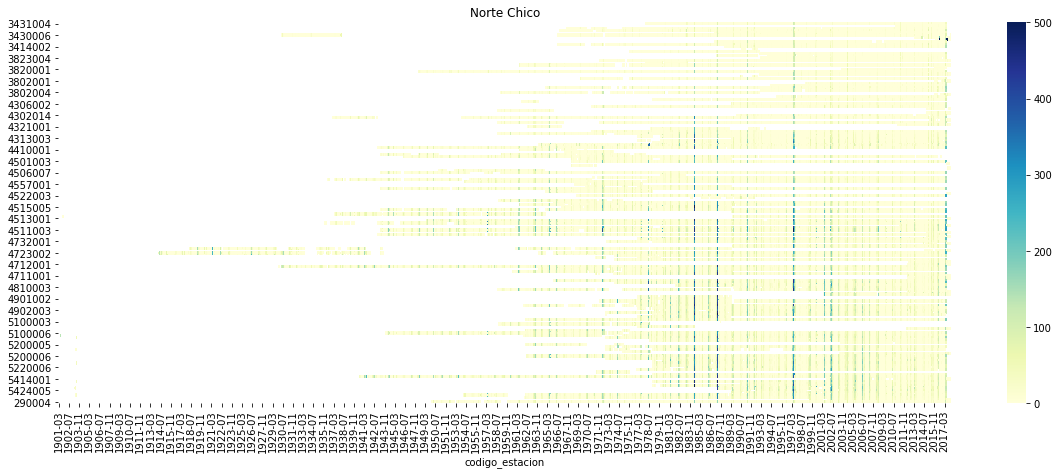

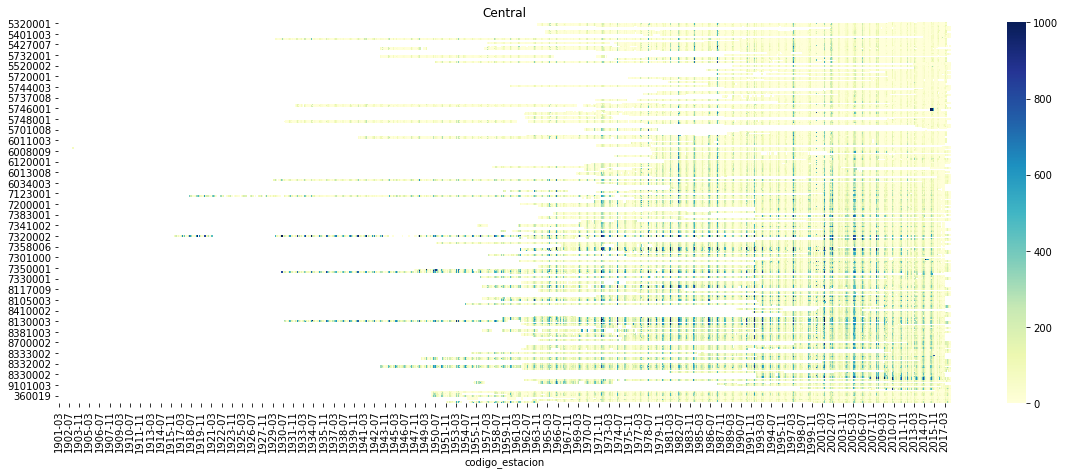

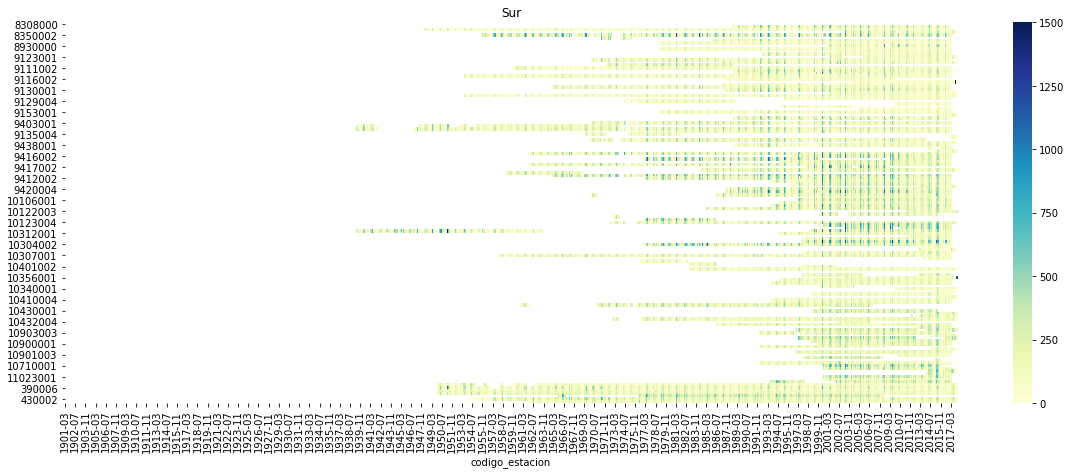

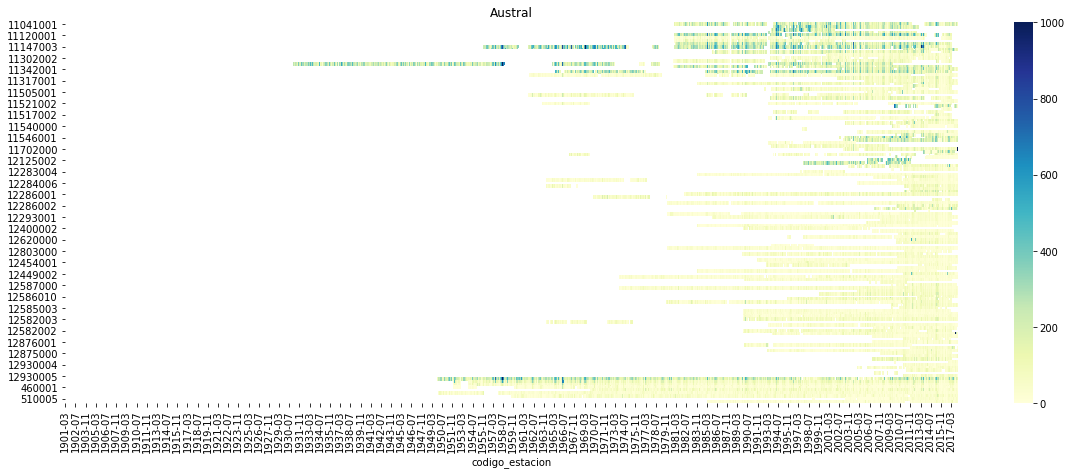

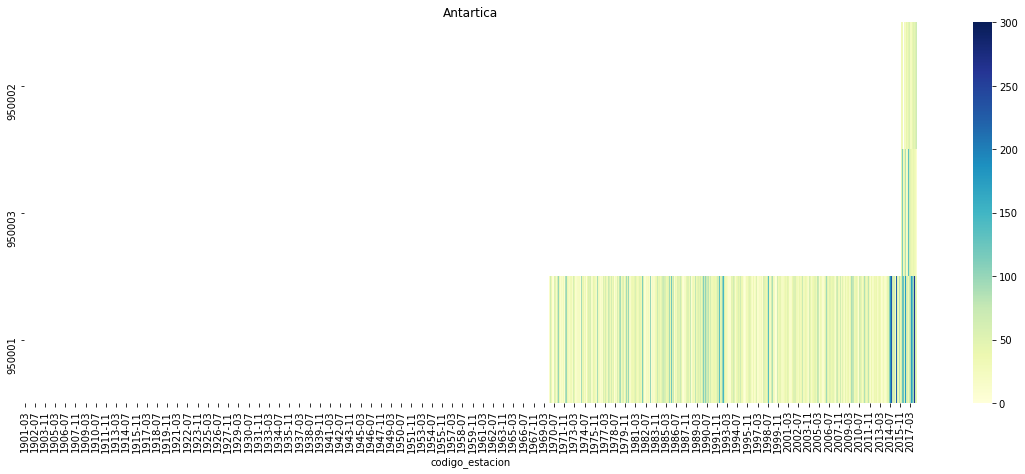

In [17]:
import seaborn as sns

intervals = {
    0: (0,350,350/2),
    1: (0,500,500/2),
    2: (0,1000,1000/2),
    3: (0,1500, 1500/2),
    4: (0, 1000, 1000/2),
    5: (0, 300, 300/2),
}

for name, group in gb:
    plt.figure(figsize = (20,7))
    plt.title(str_region(name))
    vmin,vmax,center = intervals[name]
    df = group[group.columns[14:-1]]
    sns.heatmap(df,mask = df.isnull(), cmap="YlGnBu", vmax = vmax, vmin = vmin, center = center)
    plt.show()